# 🧼 Nettoyage des données brutes Fiverr
Ce notebook reprend les **données brutes** du dataset Fiverr (téléchargées via Kaggle) et applique un **nettoyage complet** en plusieurs étapes :

🎯 Objectifs :
- Explorer les colonnes disponibles
- Supprimer les colonnes inutiles ou vides
- Nettoyer les chaînes de caractères et valeurs incohérentes
- Convertir les types de données
- Exporter un fichier nettoyé `fiverr-data-gigs-cleaned.csv`

**Compétences couvertes :** Bloc 3 C2 et Bloc 5 C1

## 📦 Importation des bibliothèques

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

sns.set(style='whitegrid')

## 📂 Chargement des données brutes Fiverr

In [75]:
# Chargement du fichier brut Fiverr (à adapter selon le nom réel)
df = pd.read_csv(
    'data/fiverr_gigs/fiverr-data-gigs.csv',
    encoding='latin-1',
    low_memory=False
)

# Vérifier les noms de colonnes bruts
print(df.columns.tolist())

['ï»¿Title', 'Title_URL', 'gigrating', '_5fo9i5', 'Price']


In [76]:
# Renommer proprement la première colonne
df.rename(columns={'ï»¿Title': 'Title'}, inplace=True)
df.rename(columns={'gigrating': 'Rating'}, inplace=True)
df.rename(columns={'_5fo9i5': 'Level'}, inplace=True)

print(df.columns.tolist())

['Title', 'Title_URL', 'Rating', 'Level', 'Price']


In [77]:
# Nettoyage des noms de colonnes pour supprimer les caractères spéciaux cachés (comme ï»¿)
#df.columns = df.columns.str.encode('utf-8').str.decode('utf-8-sig').str.strip()

# Affichage des premières lignes et dimensions
print(f"Dimensions : {df.shape}")
df.head()

Dimensions : (1259, 5)


,Title,Title_URL,Rating,Level,Price
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,5.0(56),Level 2 Seller,"PKRÂ 8,701"
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,5.0(1k+),Top Rated Seller,"PKRÂ 3,263"
2,"I will do web scraping , data scraping, scrapi...",https://www.fiverr.com/kodweb/do-web-scraping-...,5.0(63),Level 2 Seller,"PKRÂ 2,176"
3,"I will do python web scraping , data entry , a...",https://www.fiverr.com/asad__haadi/do-web-scra...,5.0(266),Level 2 Seller,"PKRÂ 1,088"
4,I will data scraping web site scraping and dat...,https://www.fiverr.com/yourbuddy/web-scraping-...,4.9(275),Level 2 Seller,"PKRÂ 4,351"


In [78]:
# 🔧 Séparation de la colonne 'Rating' en deux nouvelles colonnes

# 1. Extraire la note (avant la parenthèse) → ex : "5.0" dans "5.0(56)"
df['Rating_Score'] = df['Rating'].str.extract(r'^([\d.]+)').astype(float)

# 2. Extraire le nombre d'évaluations (dans la parenthèse) → ex : "56" dans "5.0(56)"
# Cas spéciaux : "1k+" → on convertit en 1000 ; "2.5k+" → 2500, etc.
def parse_review_count(s):
    if pd.isna(s):
        return np.nan
    match = re.search(r'\(([\d\.kK\+]+)\)', s)
    if not match:
        return np.nan
    val = match.group(1).lower().replace('+', '')
    if 'k' in val:
        try:
            return int(float(val.replace('k', '')) * 1000)
        except:
            return np.nan
    try:
        return int(val)
    except:
        return np.nan

df['Rating_Count'] = df['Rating'].apply(parse_review_count)

# 🔍 Vérification
print(df[['Rating', 'Rating_Score', 'Rating_Count']].head(10))

     Rating  Rating_Score  Rating_Count
0   5.0(56)           5.0          56.0
1  5.0(1k+)           5.0        1000.0
2   5.0(63)           5.0          63.0
3  5.0(266)           5.0         266.0
4  4.9(275)           4.9         275.0
5  5.0(181)           5.0         181.0
6  5.0(211)           5.0         211.0
7  5.0(398)           5.0         398.0
8   5.0(61)           5.0          61.0
9   5.0(16)           5.0          16.0


In [79]:
# 🔥 Suppression de la colonne initiale "Rating" devenue inutile
df.drop(columns=['Rating'], inplace=True)
# 🔍 Vérification
print(df[['Rating_Score', 'Rating_Count']].head(10))

   Rating_Score  Rating_Count
0           5.0          56.0
1           5.0        1000.0
2           5.0          63.0
3           5.0         266.0
4           4.9         275.0
5           5.0         181.0
6           5.0         211.0
7           5.0         398.0
8           5.0          61.0
9           5.0          16.0


## 🔍 Analyse des valeurs manquantes

In [80]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0].head(20)

Level           827
Rating_Score    630
Rating_Count    630
dtype: int64

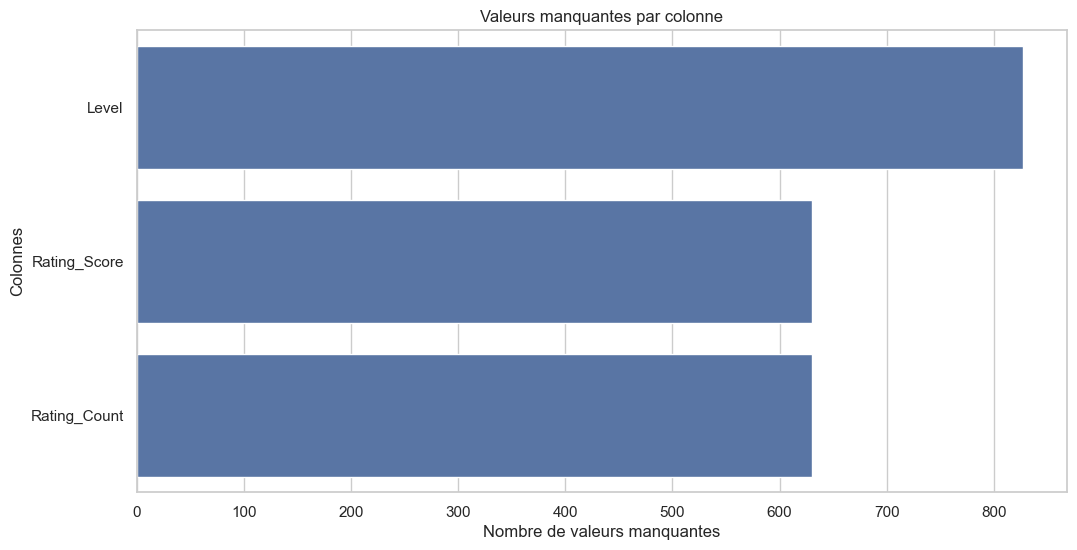

In [81]:
# Visualisation des valeurs manquantes par colonne
plt.figure(figsize=(12, 6))
sns.barplot(y=missing[missing > 0].index, x=missing[missing > 0].values)
plt.title("Valeurs manquantes par colonne")
plt.xlabel("Nombre de valeurs manquantes")
plt.ylabel("Colonnes")
plt.show()

## 🧹 Suppression des colonnes inutiles ou vides

In [82]:
# Exemple : suppression des colonnes entièrement vides ou peu utiles
empty_cols = missing[missing == len(df)].index.tolist()
df.drop(columns=empty_cols, inplace=True)
print(f"Colonnes supprimées (vides) : {empty_cols}")

Colonnes supprimées (vides) : []


## 📊 Statistiques descriptives des colonnes numériques

In [83]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Title,1259,1183,I will do machine learning python projects,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Title_URL,1259,1259,https://www.fiverr.com/maltehar/do-excel-formu...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Level,432,4,Level 2 Seller,212,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,1259,58,"PKRÂ 1,088",228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating_Score,629.0,NaN,NaN,NaN,4.955167,0.186638,1.0,5.0,5.0,5.0,5.0
Rating_Count,629.0,NaN,NaN,NaN,77.802862,179.537993,1.0,4.0,16.0,55.0,1000.0


## 📈 Visualisation des distributions numériques

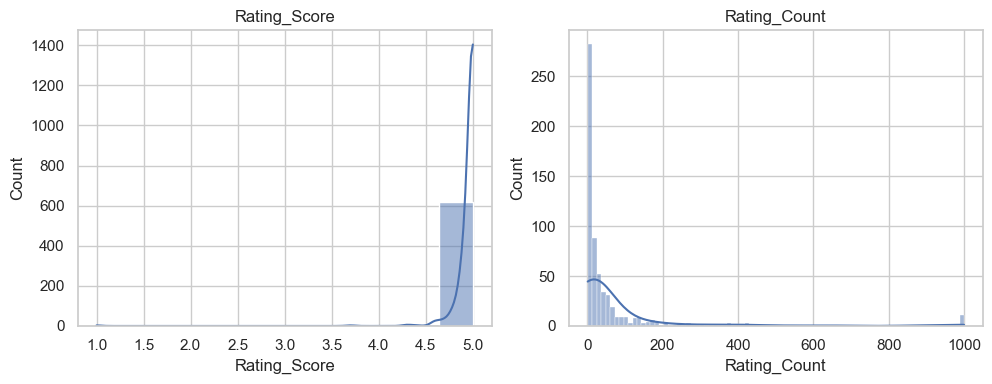

In [84]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

## ✏️ Nettoyage des chaînes de caractères

Cette étape vise à préparer les colonnes textuelles et numériques mal formatées :

- **Pourquoi maintenant ?**  
  Car les modèles d’analyse et de machine learning exigent des formats cohérents (texte propre, nombres au bon format).

- **Colonne `Title`** :  
  On supprime les espaces en début/fin de chaîne (`str.strip()`), souvent invisibles mais gênants pour la comparaison ou la vectorisation.

- **Colonne `Price`** :  
  Ce champ contient à la fois :
  - une **devise locale non utile ici** (`PKR`, `Â`),
  - des **caractères spéciaux** (espaces insécables, séparateurs),
  - des **virgules** en tant que séparateurs de milliers (à supprimer).
  
  L’objectif est d’obtenir un champ **numérique exploitable**, en `float`, prêt pour l’analyse statistique et la modélisation.

- **Pourquoi ne pas convertir immédiatement avec `pd.to_numeric()` ?**  
  Parce que les caractères parasites empêchent la détection automatique. Il faut d’abord les nettoyer.

➡️ Cette étape est essentielle pour assurer la qualité du dataset et éviter les erreurs futures.


In [85]:
# Suppression des espaces superflus sur la colonne 'Title'
df['Title'] = df['Title'].astype(str).str.strip()

# Nettoyage de la colonne 'Price'
# Étapes :
# 1. Supprimer les caractères non numériques (lettres, devises, espaces, caractères spéciaux)
# 2. Supprimer les séparateurs de milliers ','
# 3. Convertir en float

df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace(r'[^\d,]', '', regex=True)  # supprimer tout sauf chiffres et virgule
    .str.replace(',', '.')                   # supprimer les virgules
    .replace('', np.nan)                    # convertir les cellules vides en NaN
)

# Vérification
print(df['Price'].head())


0    8.701
1    3.263
2    2.176
3    1.088
4    4.351
Name: Price, dtype: object


## 💾 Export du fichier nettoyé

In [86]:
df.to_csv('data/fiverr_gigs/fiverr-data-gigs-cleaned.csv', index=False, encoding='utf-8')
print("✅ Fichier exporté : fiverr-data-gigs-cleaned.csv")

✅ Fichier exporté : fiverr-data-gigs-cleaned.csv


In [87]:
df

,Title,Title_URL,Level,Price,Rating_Score,Rating_Count
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,Level 2 Seller,8.701,5.0,56.0
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,Top Rated Seller,3.263,5.0,1000.0
2,"I will do web scraping , data scraping, scrapi...",https://www.fiverr.com/kodweb/do-web-scraping-...,Level 2 Seller,2.176,5.0,63.0
3,"I will do python web scraping , data entry , a...",https://www.fiverr.com/asad__haadi/do-web-scra...,Level 2 Seller,1.088,5.0,266.0
4,I will data scraping web site scraping and dat...,https://www.fiverr.com/yourbuddy/web-scraping-...,Level 2 Seller,4.351,4.9,275.0
...,...,...,...,...,...,...
1254,I will do any natural language processing or n...,https://www.fiverr.com/python_expertz/do-any-n...,NaN,2.176,4.9,22.0
1255,I will make your machine learning projects in ...,https://www.fiverr.com/djangomaster1/make-your...,Level 1 Seller,6.526,4.9,56.0
1256,I will do machine learning python projects,https://www.fiverr.com/codeflirty/do-machine-l...,NaN,27.189,5.0,22.0
1257,I will do machine learning projects in python,https://www.fiverr.com/jarypo/machine-learning...,Level 2 Seller,18.489,4.9,38.0
